In [8]:
import requests
import pandas as pd
from pandas import read_html
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def get_odstavky(df,od,do):
    indexes = df['Event Start']
    df.index= indexes
    dat = df

    dat.index = dat.index.astype('string').str.split('+',expand=True).droplevel(1)
    dat.index = pd.to_datetime(dat.index)

    dat['Event Start'] = dat['Event Start'].astype('string').str.split('+',expand=True).iloc[:,0]
    dat['Event Start'] = pd.to_datetime(dat['Event Start'])
    dat['Event Start'] = dat['Event Start'].round('H')
    dat['Event Stop'] = dat['Event Stop'].astype('string').str.split('+',expand=True).iloc[:,0]
    dat['Event Stop'] = pd.to_datetime(dat['Event Stop'])
    dat['Event Stop'] = dat['Event Stop'].round('H')

    dat['Odstavka'] = dat['Technical Capacity'] - dat['Available Capacity']

    lst = pd.date_range(start=od, end=do, freq='1H')

    # create new DataFrame
    df2 = pd.DataFrame(0, index=lst, columns=dat['Affected Asset or Unit'].unique())

    # loop over assets and dates and aggregate data for each day
    for col in df2.columns:
        for date in df2.index:
            mask = (dat['Event Start'] <= date) & (dat['Event Stop'] >= date) & (dat['Affected Asset or Unit'] == col)
            df2.loc[date, col] = dat.loc[mask]['Odstavka'].sum()

    # aggregate data for each day and add retrieved date
    df2['Odstavka'] = df2.sum(axis=1)
    df2 = df2[['Odstavka']]
    df2['Retrieved'] = pd.Timestamp.now().floor('D').strftime("%Y-%m-%d")
    return df2

In [10]:
s=requests.session()
s1=s.get("https://umm.gassco.no")
s2=s.get("https://umm.gassco.no/disclaimer/acceptDisclaimer?")
data = read_html(s2.text, attrs={"class": "msgTable"})
df = pd.DataFrame(data[0])
exit_terminals = pd.DataFrame(data[1])

In [4]:
start = "2023-01-01"
end = "2024-01-01"

In [47]:
new_df = get_odstavky(df,start,end)

In [11]:
import os.path

# set file path and name
file_path = 'odstavky91.xlsx'

# check if file exists
if os.path.isfile(file_path):
    # read existing file
    existing_data = pd.read_excel(file_path)
    
    # check if last retrieved date is today
    last_date = pd.to_datetime(existing_data['Retrieved'].iloc[-1])
    today = pd.Timestamp.now().floor('D')
    
    if last_date == today:
        # do nothing
        pass
    else:
        # download new data
        new_data = get_odstavky(df, start, end)
        
        # append new data to existing file
        updated_data = existing_data.append(new_data)
        updated_data.to_excel(file_path, index=False)
else:
    # download new data and create new file
    new_data = get_odstavky(df, start, end)
    new_data.to_excel(file_path, index=False)


C:\Users\exlamajd\AppData\Local\Temp\ipykernel_2680\3223141141.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_data = existing_data.append(new_data)


In [13]:
updated_data

,Unnamed: 0,Odstavka,Retrieved
0,2023-01-01,1.1,2023-04-19
1,2023-01-02,1.1,2023-04-19
2,2023-01-03,1.1,2023-04-19
3,2023-01-04,1.1,2023-04-19
4,2023-01-05,1.1,2023-04-19
...,...,...,...
2023-12-31 20:00:00,NaT,0.0,2023-04-20
2023-12-31 21:00:00,NaT,0.0,2023-04-20
2023-12-31 22:00:00,NaT,0.0,2023-04-20
2023-12-31 23:00:00,NaT,0.0,2023-04-20


In [41]:
new_df.to_excel("odstavky91.xlsx")

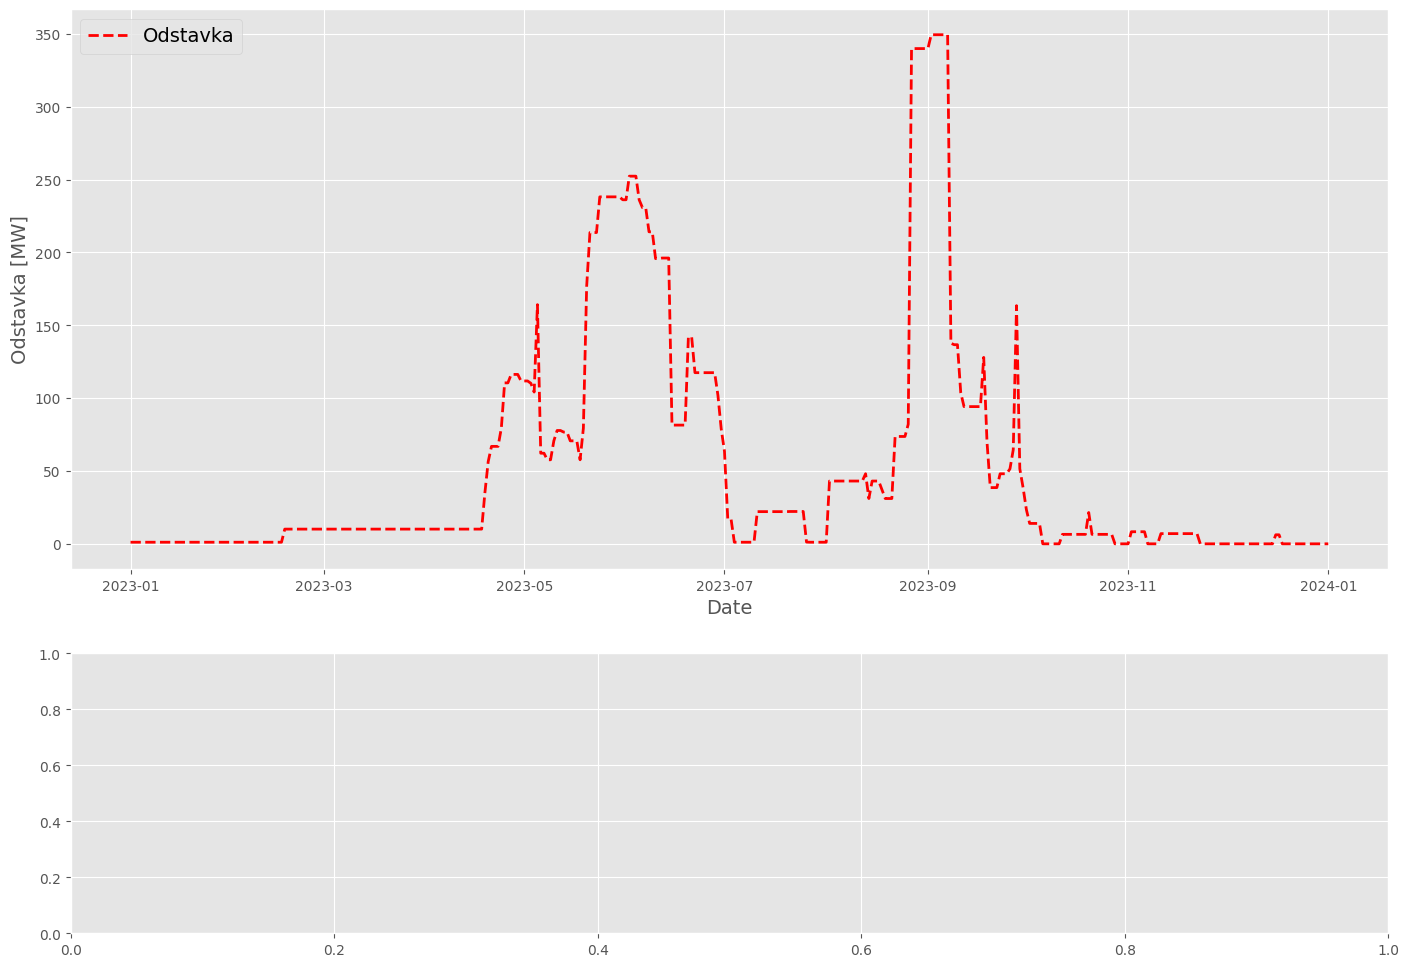

In [31]:
# plot

plt.style.use('ggplot')

fig,(ax1, ax2) = plt.subplots(2, figsize = (17,12), gridspec_kw={'height_ratios': [2, 1]})
ax1.plot(new_df.index,new_df['Odstavka'],color = 'red',linestyle = '--',linewidth=2,label = 'Odstavka')
ax1.set_ylabel('Odstavka [MW]',fontsize = 14)
ax1.set_xlabel('Date',fontsize = 14)
ax1.legend(loc = 'upper left',fontsize = 14)
ax1.grid(True)



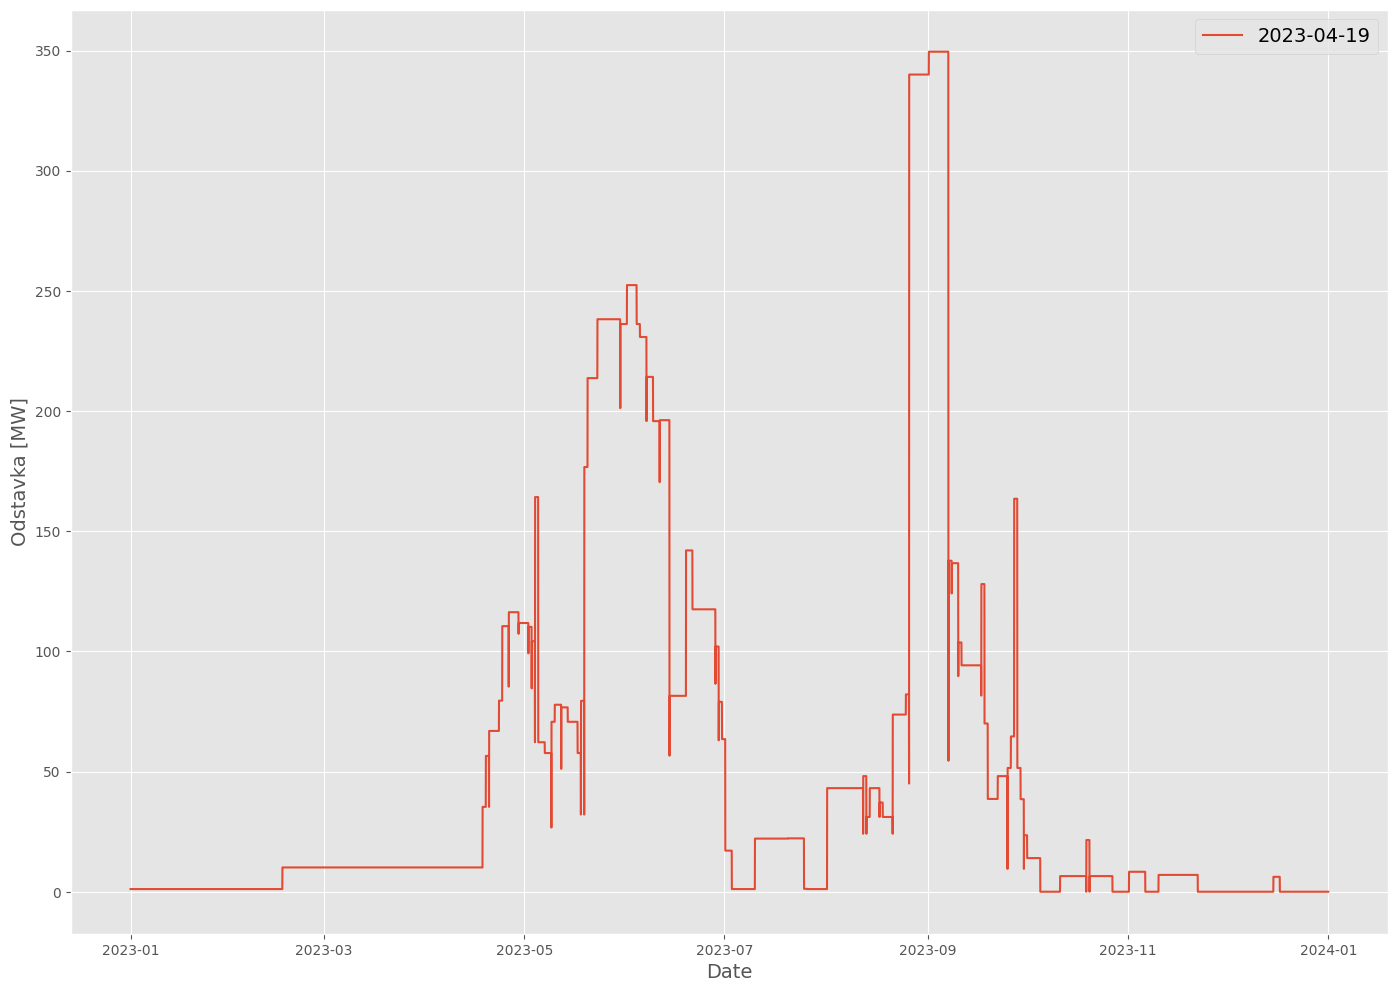

In [7]:
# group by Retrieved column
grouped = new_df.groupby(new_df['Retrieved'])

# create a new figure
fig, ax = plt.subplots(figsize=(17, 12))

# iterate over groups and plot a line for each group
for group_name, group_data in grouped:
    ax.plot(group_data.index, group_data['Odstavka'], label=group_name)

# set labels, legend, and grid
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Odstavka [MW]', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)